# Random-based Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from rand_exp_utils import *

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_rand = config["path_rand"]
thresholds = config["thresholds"]
only_load = config["only_load"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Models

In [3]:
from load_models import prepare_models

# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.

'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


## Load Datasets

In [4]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Inference on Full Text

### BERTTurk

In [5]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

### TurkishBERTweet

In [6]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

## Random-based Explainability

In [7]:
all_exp_results = pd.DataFrame(columns=["ECS", "ORC (+)", "ORC (-)"])

In [8]:
num_samples = 50

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

### BERTTurk

#### TTC4900

In [9]:
ttc4900_bert_results = {}

for threshold in thresholds:

    rand_values_ttc = apply_random(path_rand, ttc4900_test, bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                   f"rand_values_ttc_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(rand_values_ttc, bert_tokenizer_ttc4900, threshold)

    rand_values_ttc_short = apply_random(path_rand, top_tokens_ttc4900, bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                         f"rand_values_ttc_short_{threshold}_bert", device, only_load=only_load)

    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        1,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        bert_pipeline_text_ttc4900,
                                        pipeline_parameters,
                                        device, 
                                        bert_id2label_ttc4900)

    ttc4900_bert_results[threshold] = (rand_values_ttc, rand_values_ttc_short, ttc4900_bert_result)
    
    clear_gpu_memory()
    
    show(ttc4900_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_ttc_0.5_bert' file shape: 50
'rand_values_ttc_short_0.5_bert' file shape: 50


'rand_values_ttc_0.6_bert' file shape: 50
'rand_values_ttc_short_0.6_bert' file shape: 50


'rand_values_ttc_0.7_bert' file shape: 50
'rand_values_ttc_short_0.7_bert' file shape: 50



Explanations Contribution Score (ECS)          :  0.975
Overall Relative Change (ORC) positive changes :  4.967 %
Overall Relative Change (ORC) negative changes : -1.418 %


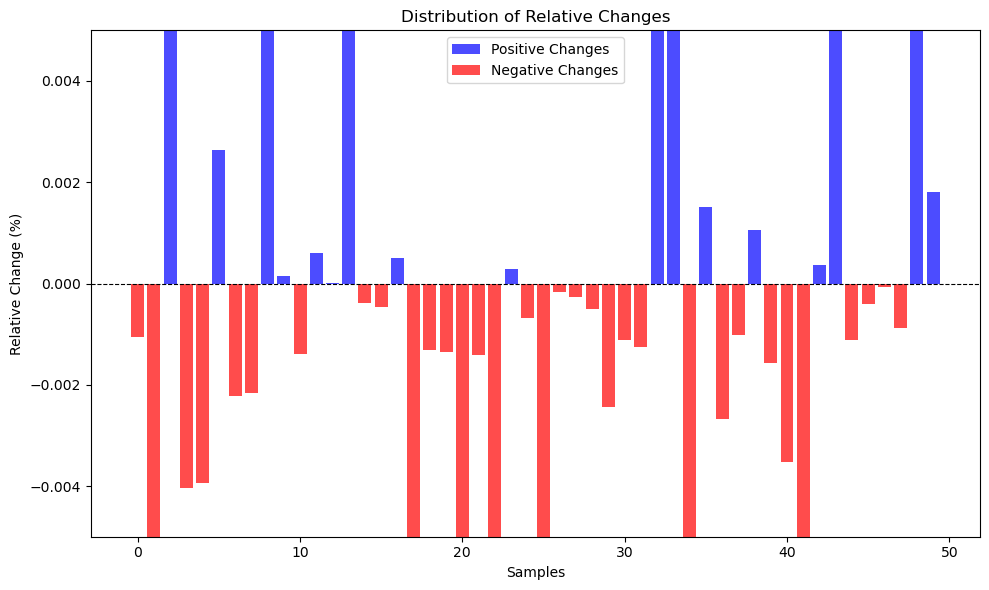


Explanations Contribution Score (ECS)          :  0.983
Overall Relative Change (ORC) positive changes :  5.627 %
Overall Relative Change (ORC) negative changes : -0.558 %


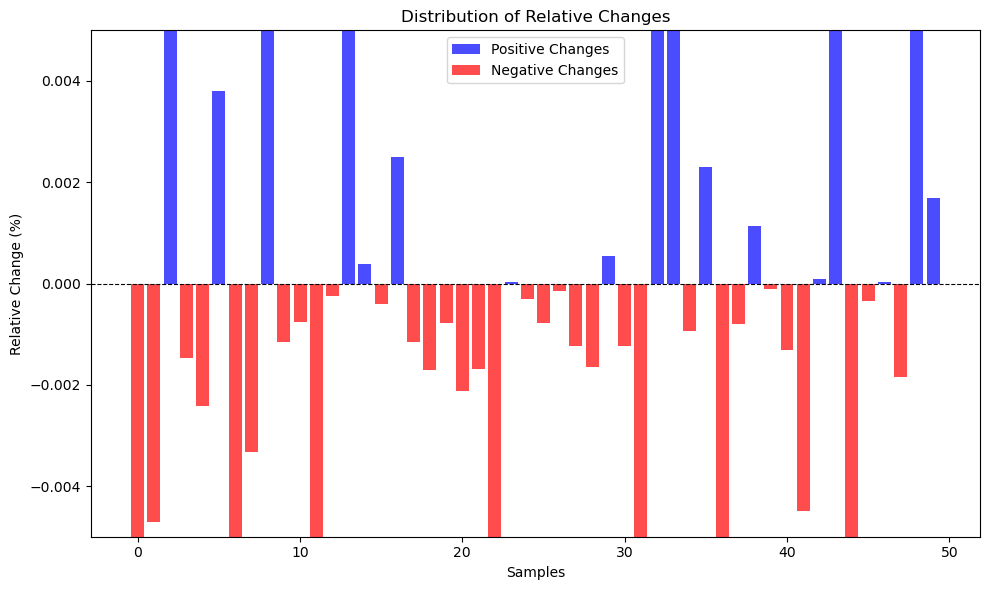


Explanations Contribution Score (ECS)          :  0.956
Overall Relative Change (ORC) positive changes :  6.198 %
Overall Relative Change (ORC) negative changes : -4.251 %


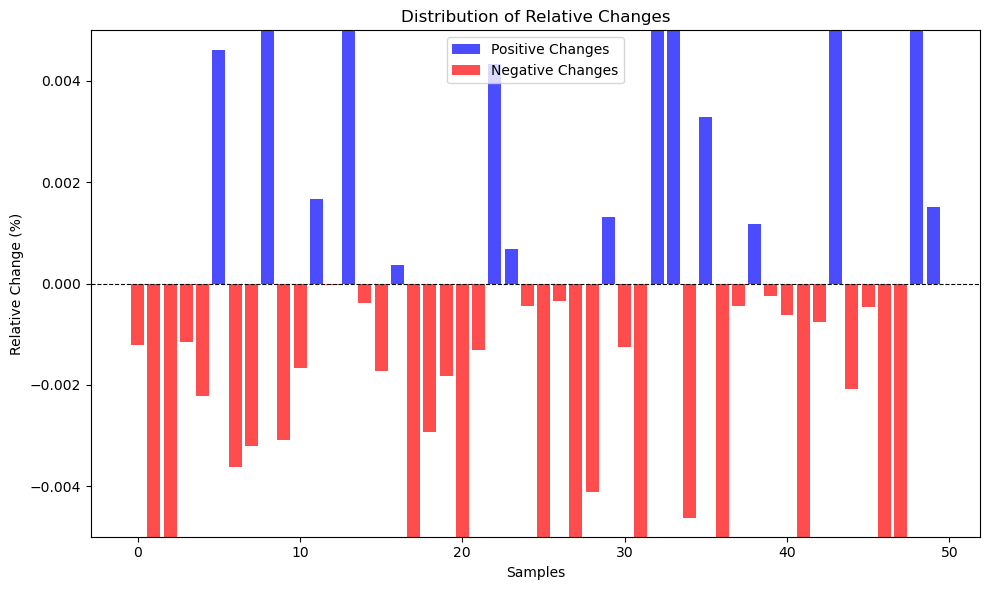

In [10]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [11]:
tr_news_bert_results = {}

for threshold in thresholds:

    rand_values_tr_news = apply_random(path_rand, tr_news_test, bert_model_tr_news, bert_tokenizer_tr_news, 
                                   f"rand_values_tr_news_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(rand_values_tr_news, bert_tokenizer_tr_news, threshold)

    rand_values_tr_news_short = apply_random(path_rand, top_tokens_tr_news, bert_model_tr_news, bert_tokenizer_tr_news, 
                                         f"rand_values_tr_news_short_{threshold}_bert", device, only_load=only_load)

    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        1,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        bert_pipeline_text_tr_news,
                                        pipeline_parameters,
                                        device, 
                                        bert_id2label_tr_news)

    tr_news_bert_results[threshold] = (rand_values_tr_news, rand_values_tr_news_short, tr_news_bert_result)
    
    clear_gpu_memory()
    
    show(tr_news_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_tr_news_0.5_bert' file shape: 50
'rand_values_tr_news_short_0.5_bert' file shape: 50


'rand_values_tr_news_0.6_bert' file shape: 50
'rand_values_tr_news_short_0.6_bert' file shape: 50


'rand_values_tr_news_0.7_bert' file shape: 50
'rand_values_tr_news_short_0.7_bert' file shape: 50



Explanations Contribution Score (ECS)          :  0.812
Overall Relative Change (ORC) positive changes :  18.261 %
Overall Relative Change (ORC) negative changes : -18.207 %


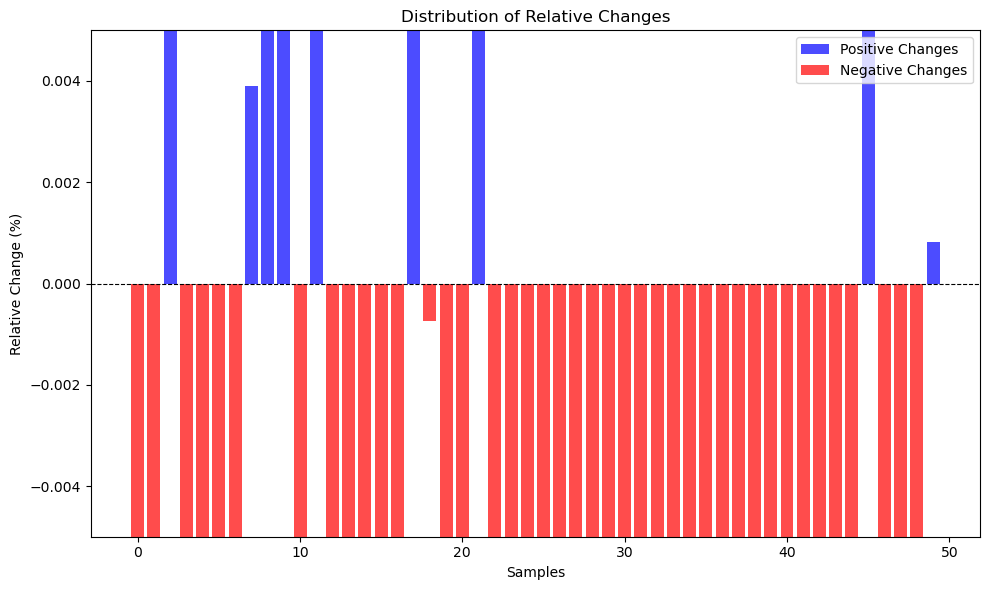


Explanations Contribution Score (ECS)          :  0.796
Overall Relative Change (ORC) positive changes :  16.385 %
Overall Relative Change (ORC) negative changes : -22.553 %


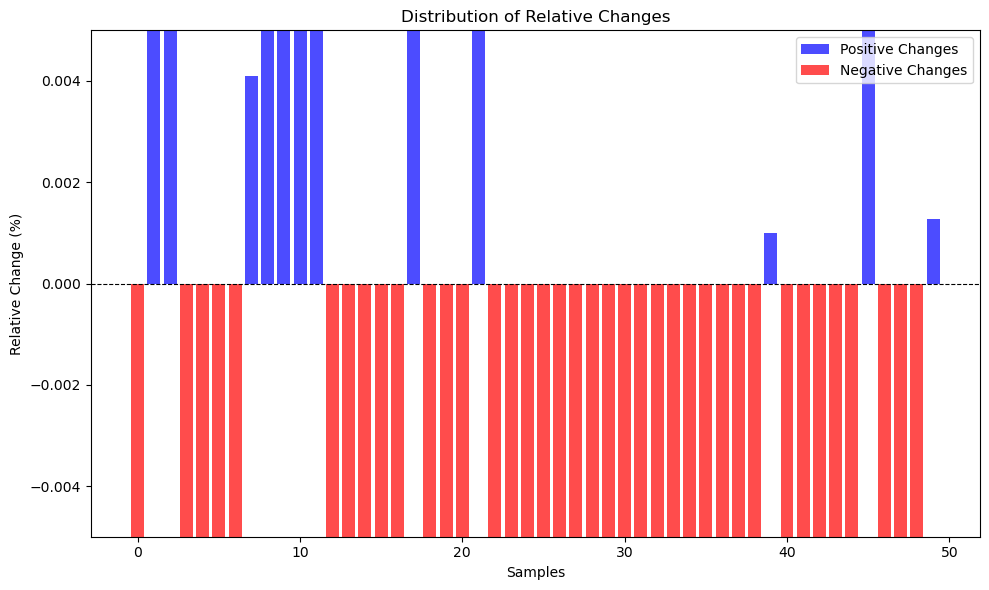


Explanations Contribution Score (ECS)          :  0.782
Overall Relative Change (ORC) positive changes :  20.775 %
Overall Relative Change (ORC) negative changes : -22.485 %


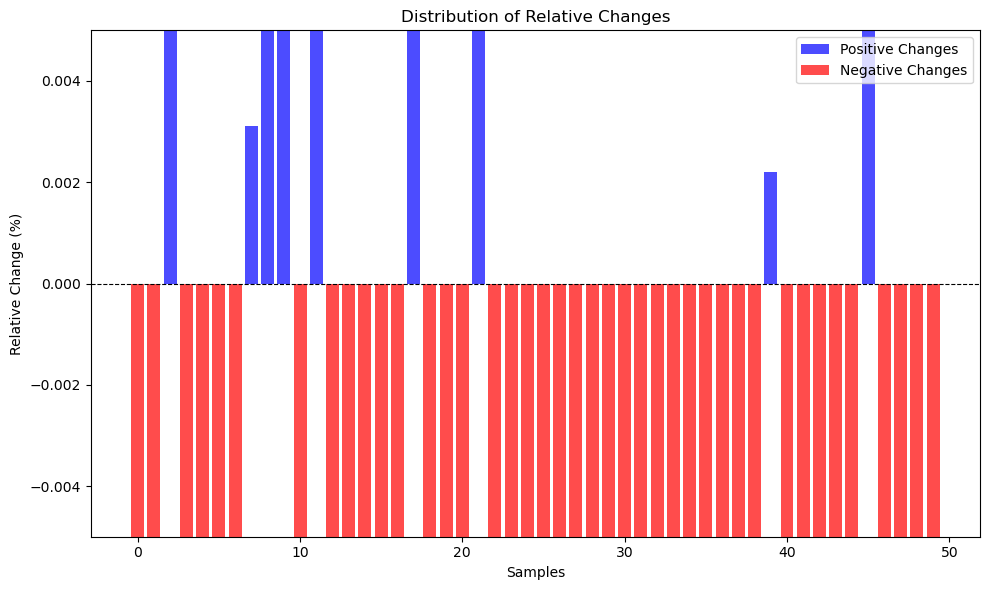

In [12]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [13]:
interpress_bert_results = {}

for threshold in thresholds:

    rand_values_interpress = apply_random(path_rand, interpress_test, bert_model_interpress, bert_tokenizer_interpress, 
                                   f"rand_values_interpress_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(rand_values_interpress, bert_tokenizer_interpress, threshold)

    rand_values_interpress_short = apply_random(path_rand, top_tokens_interpress, bert_model_interpress, bert_tokenizer_interpress, 
                                         f"rand_values_interpress_short_{threshold}_bert", device, only_load=only_load)

    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           1,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           bert_pipeline_text_interpress,
                                           pipeline_parameters,
                                           device, 
                                           bert_id2label_interpress)

    interpress_bert_results[threshold] = (rand_values_interpress, rand_values_interpress_short, interpress_bert_result)
    
    clear_gpu_memory()
    
    show(interpress_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_interpress_0.5_bert' file shape: 50
'rand_values_interpress_short_0.5_bert' file shape: 50


'rand_values_interpress_0.6_bert' file shape: 50
'rand_values_interpress_short_0.6_bert' file shape: 50


'rand_values_interpress_0.7_bert' file shape: 50
'rand_values_interpress_short_0.7_bert' file shape: 50



Explanations Contribution Score (ECS)          :  0.925
Overall Relative Change (ORC) positive changes :  9.354 %
Overall Relative Change (ORC) negative changes : -8.089 %


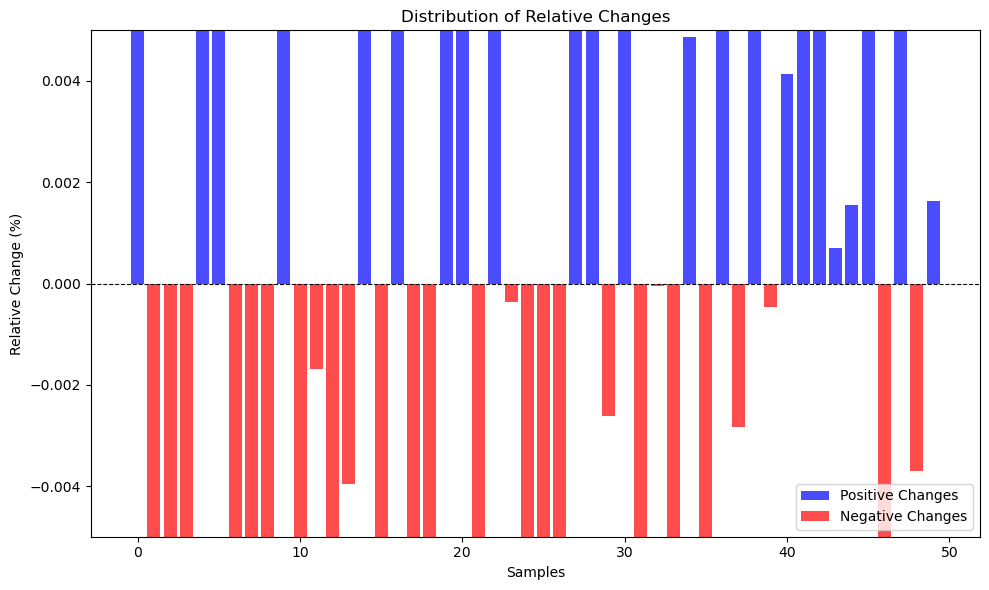


Explanations Contribution Score (ECS)          :  0.898
Overall Relative Change (ORC) positive changes :  12.184 %
Overall Relative Change (ORC) negative changes : -13.631 %


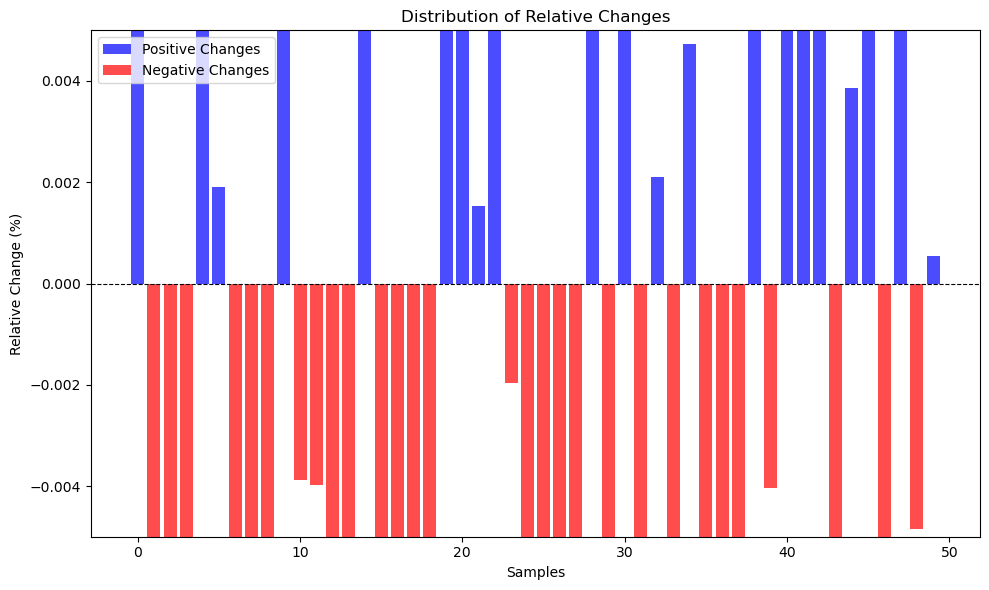


Explanations Contribution Score (ECS)          :  0.896
Overall Relative Change (ORC) positive changes :  12.123 %
Overall Relative Change (ORC) negative changes : -10.829 %


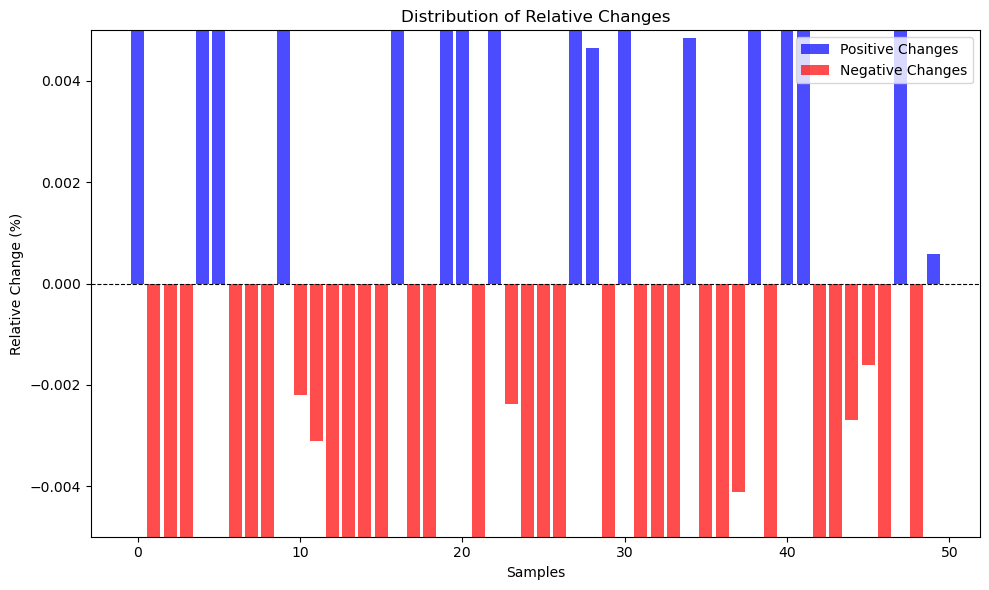

In [14]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [15]:
tc32_bert_results = {}

for threshold in thresholds:

    rand_values_tc32 = apply_random(path_rand, tc32_test, bert_model_tc32, bert_tokenizer_tc32, 
                                   f"rand_values_tc32_{threshold}_bert", device, only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(rand_values_tc32, bert_tokenizer_tc32, threshold)

    rand_values_tc32_short = apply_random(path_rand, top_tokens_tc32, bert_model_tc32, bert_tokenizer_tc32, 
                                         f"rand_values_tc32_short_{threshold}_bert", device, only_load=only_load)

    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     1,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     bert_pipeline_text_tc32,
                                     pipeline_parameters,
                                     device, 
                                     bert_id2label_tc32)

    tc32_bert_results[threshold] = (rand_values_tc32, rand_values_tc32_short, tc32_bert_result)
    
    clear_gpu_memory()
    
    show(tc32_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_tc32_0.5_bert' file shape: 50
'rand_values_tc32_short_0.5_bert' file shape: 50


'rand_values_tc32_0.6_bert' file shape: 50
'rand_values_tc32_short_0.6_bert' file shape: 50


'rand_values_tc32_0.7_bert' file shape: 50
'rand_values_tc32_short_0.7_bert' file shape: 50



Explanations Contribution Score (ECS)          :  0.829
Overall Relative Change (ORC) positive changes :  6.657 %
Overall Relative Change (ORC) negative changes : -18.18 %


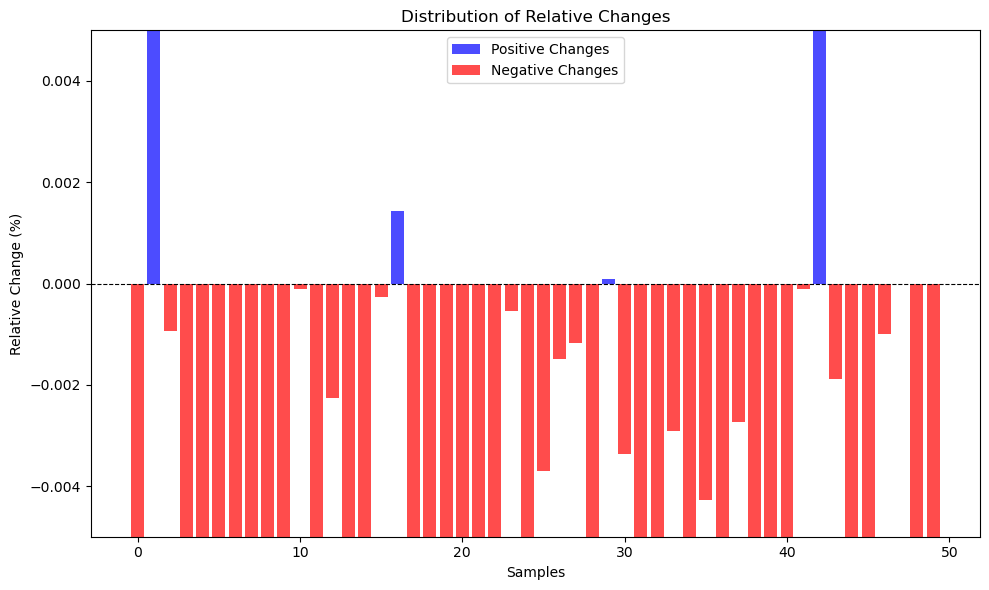


Explanations Contribution Score (ECS)          :  0.879
Overall Relative Change (ORC) positive changes :  6.732 %
Overall Relative Change (ORC) negative changes : -13.645 %


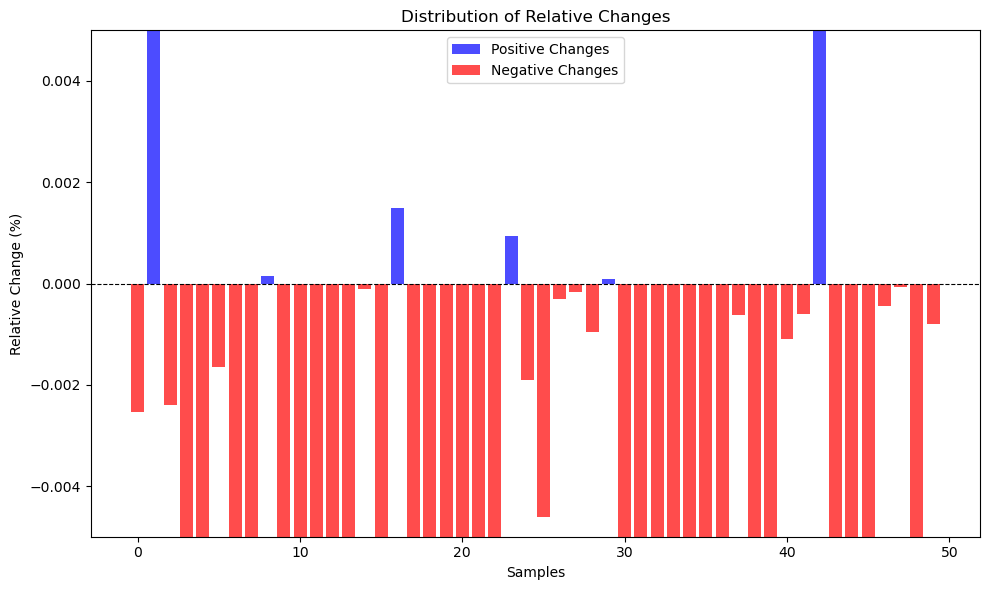


Explanations Contribution Score (ECS)          :  0.811
Overall Relative Change (ORC) positive changes :  8.026 %
Overall Relative Change (ORC) negative changes : -20.861 %


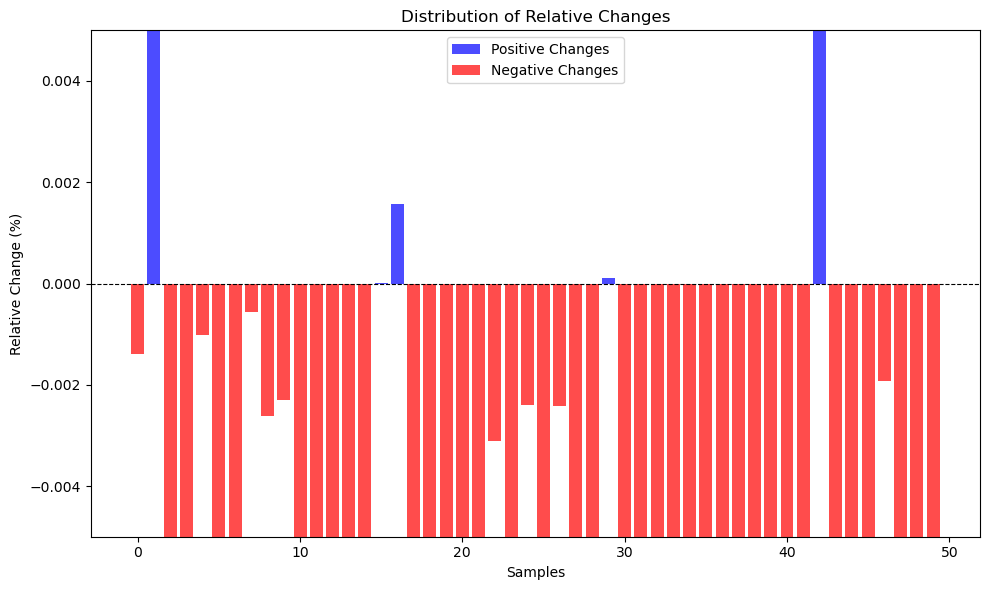

In [16]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### TTC4900

In [17]:
ttc4900_tbt_results = {}

for threshold in thresholds:

    rand_values_ttc = apply_random(path_rand, ttc4900_test, tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                   f"rand_values_ttc_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(rand_values_ttc, tbt_tokenizer_ttc4900, threshold)

    rand_values_ttc_short = apply_random(path_rand, top_tokens_ttc4900, tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                         f"rand_values_ttc_short_{threshold}_tbt", device, only_load=only_load)

    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       1,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       tbt_pipeline_text_ttc4900,
                                       pipeline_parameters,
                                       device, 
                                       tbt_id2label_ttc4900)

    ttc4900_tbt_results[threshold] = (rand_values_ttc, rand_values_ttc_short, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
    show(ttc4900_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_ttc_0.5_tbt' file shape: 50
'rand_values_ttc_short_0.5_tbt' file shape: 50


'rand_values_ttc_0.6_tbt' file shape: 50
'rand_values_ttc_short_0.6_tbt' file shape: 50


'rand_values_ttc_0.7_tbt' file shape: 50
'rand_values_ttc_short_0.7_tbt' file shape: 50



Explanations Contribution Score (ECS)          :  0.979
Overall Relative Change (ORC) positive changes :  2.721 %
Overall Relative Change (ORC) negative changes : -1.396 %


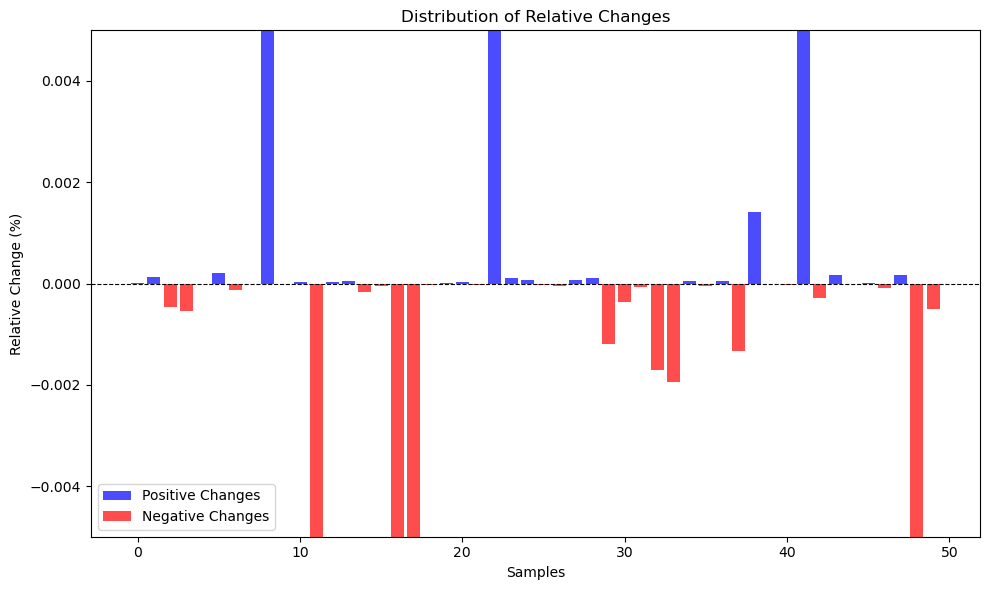


Explanations Contribution Score (ECS)          :  0.998
Overall Relative Change (ORC) positive changes :  5.291 %
Overall Relative Change (ORC) negative changes : -0.073 %


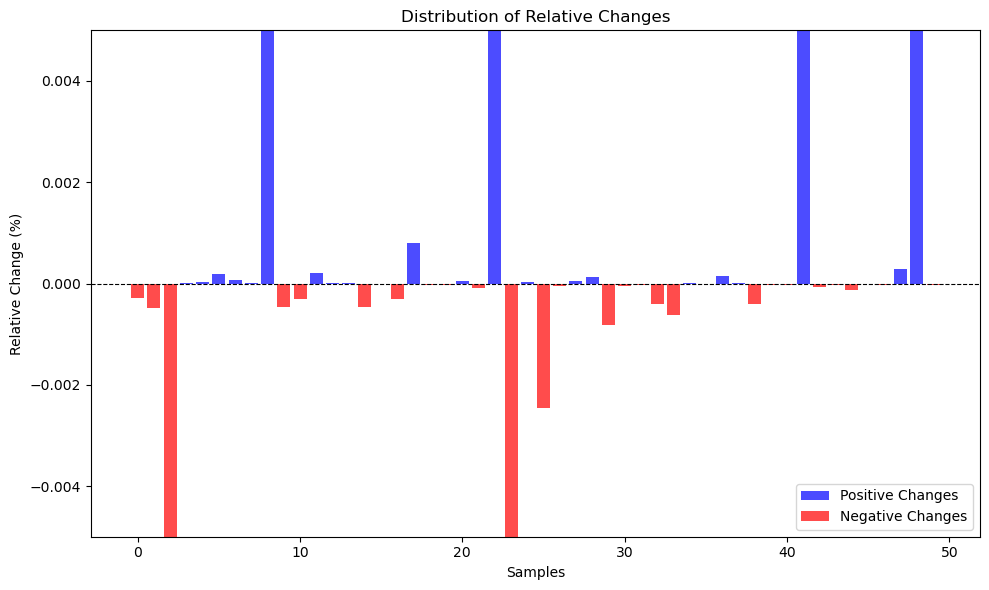


Explanations Contribution Score (ECS)          :  0.972
Overall Relative Change (ORC) positive changes :  3.745 %
Overall Relative Change (ORC) negative changes : -3.141 %


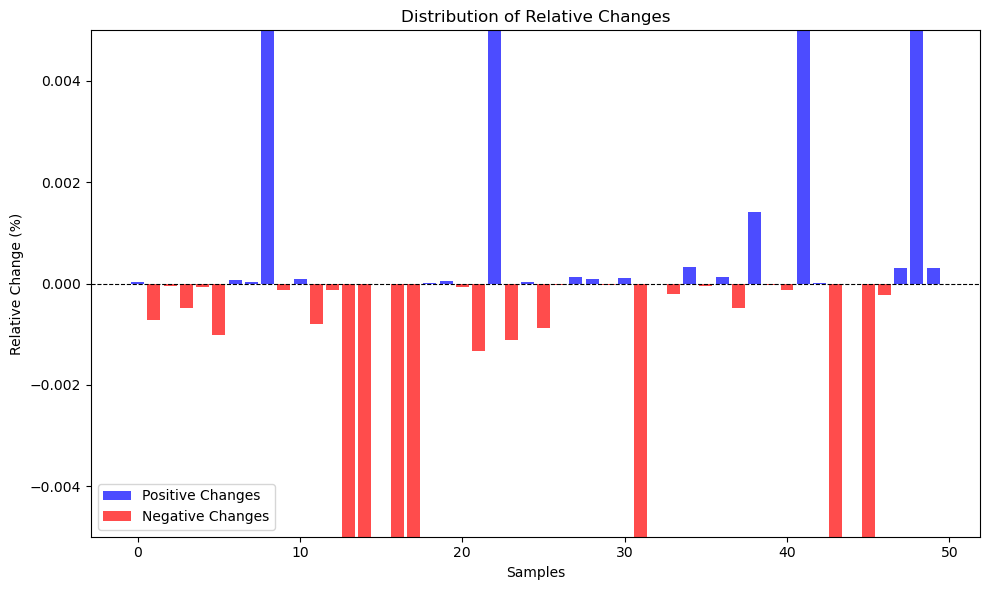

In [18]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [19]:
tr_news_tbt_results = {}

for threshold in thresholds:

    rand_values_tr_news = apply_random(path_rand, tr_news_test, tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                   f"rand_values_tr_news_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(rand_values_tr_news, tbt_tokenizer_tr_news, threshold)

    rand_values_tr_news_short = apply_random(path_rand, top_tokens_tr_news, tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                         f"rand_values_tr_news_short_{threshold}_tbt", device, only_load=only_load)

    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       1,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       tbt_pipeline_text_tr_news,
                                       pipeline_parameters,
                                       device, 
                                       tbt_id2label_tr_news)

    tr_news_tbt_results[threshold] = (rand_values_tr_news, rand_values_tr_news_short, tr_news_tbt_result)
    
    clear_gpu_memory()
    
    show(tr_news_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_tr_news_0.5_tbt' file shape: 50
'rand_values_tr_news_short_0.5_tbt' file shape: 50


'rand_values_tr_news_0.6_tbt' file shape: 50
'rand_values_tr_news_short_0.6_tbt' file shape: 50


'rand_values_tr_news_0.7_tbt' file shape: 50
'rand_values_tr_news_short_0.7_tbt' file shape: 50



Explanations Contribution Score (ECS)          :  0.76
Overall Relative Change (ORC) positive changes :  9.558 %
Overall Relative Change (ORC) negative changes : -23.256 %


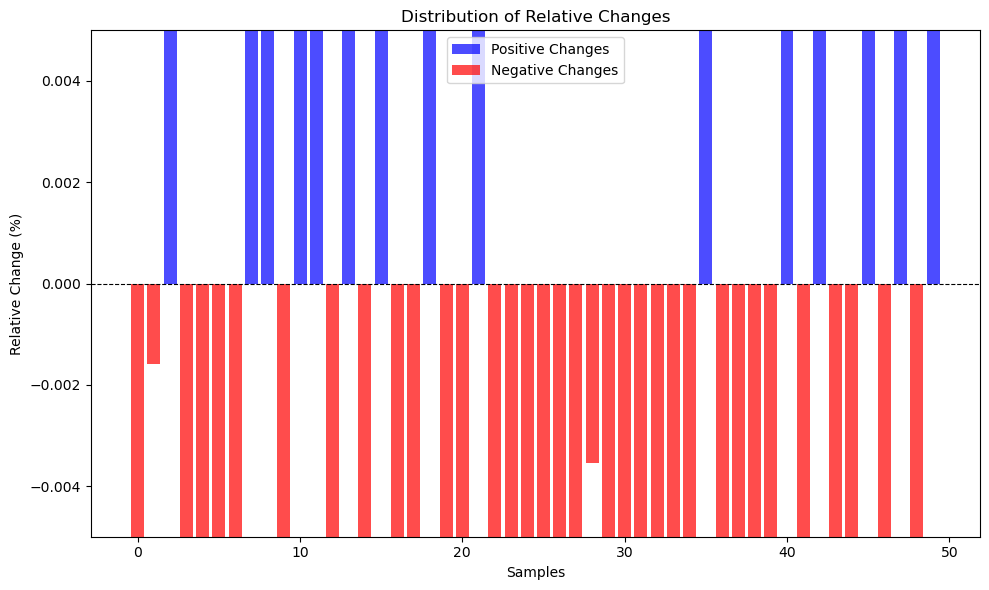


Explanations Contribution Score (ECS)          :  0.779
Overall Relative Change (ORC) positive changes :  10.875 %
Overall Relative Change (ORC) negative changes : -22.005 %


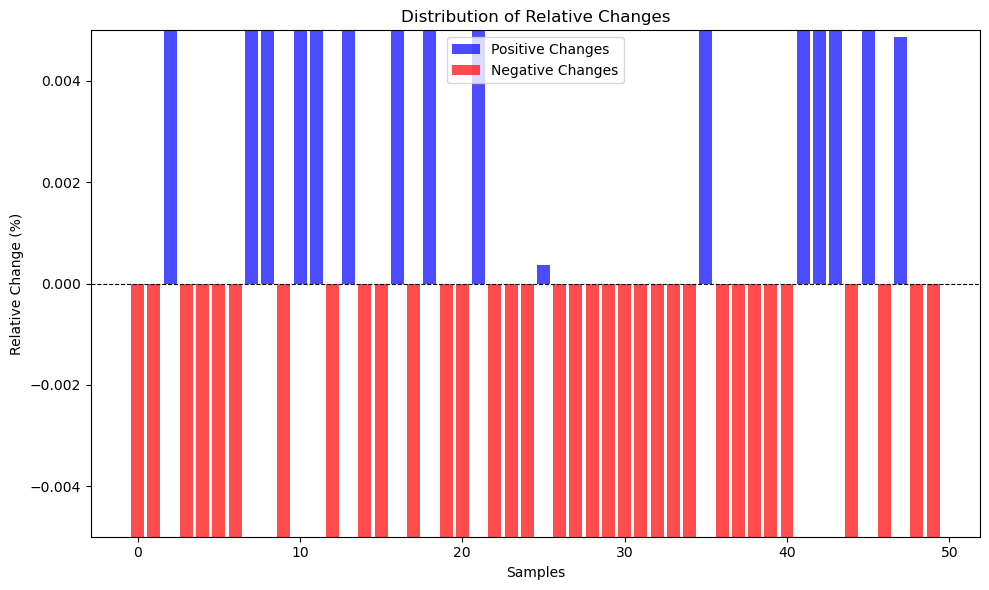


Explanations Contribution Score (ECS)          :  0.722
Overall Relative Change (ORC) positive changes :  10.377 %
Overall Relative Change (ORC) negative changes : -27.921 %


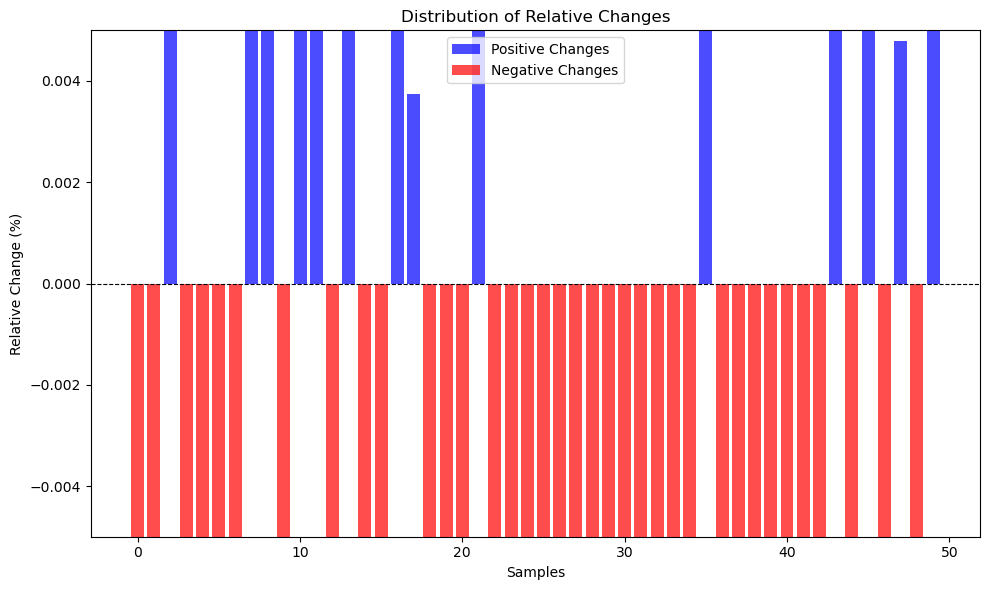

In [20]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [21]:
interpress_tbt_results = {}

for threshold in thresholds:

    rand_values_interpress = apply_random(path_rand, interpress_test, tbt_model_interpress, tbt_tokenizer_interpress, 
                                   f"rand_values_interpress_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(rand_values_interpress, tbt_tokenizer_interpress, threshold)

    rand_values_interpress_short = apply_random(path_rand, top_tokens_interpress, tbt_model_interpress, tbt_tokenizer_interpress, 
                                         f"rand_values_interpress_short_{threshold}_tbt", device, only_load=only_load)

    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          1,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          tbt_pipeline_text_interpress,
                                          pipeline_parameters,
                                          device, 
                                          tbt_id2label_interpress)

    interpress_tbt_results[threshold] = (rand_values_interpress, rand_values_interpress_short, interpress_tbt_result)
    
    clear_gpu_memory()
    
    show(interpress_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_interpress_0.5_tbt' file shape: 50
'rand_values_interpress_short_0.5_tbt' file shape: 50


'rand_values_interpress_0.6_tbt' file shape: 50
'rand_values_interpress_short_0.6_tbt' file shape: 50


'rand_values_interpress_0.7_tbt' file shape: 50
'rand_values_interpress_short_0.7_tbt' file shape: 50



Explanations Contribution Score (ECS)          :  0.809
Overall Relative Change (ORC) positive changes :  21.815 %
Overall Relative Change (ORC) negative changes : -25.428 %


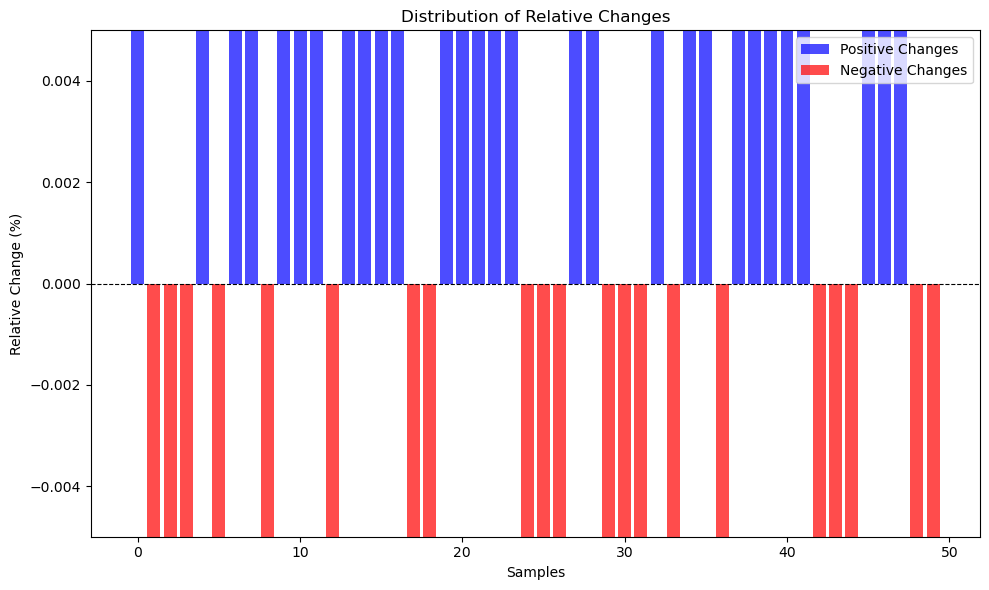


Explanations Contribution Score (ECS)          :  0.818
Overall Relative Change (ORC) positive changes :  24.894 %
Overall Relative Change (ORC) negative changes : -19.142 %


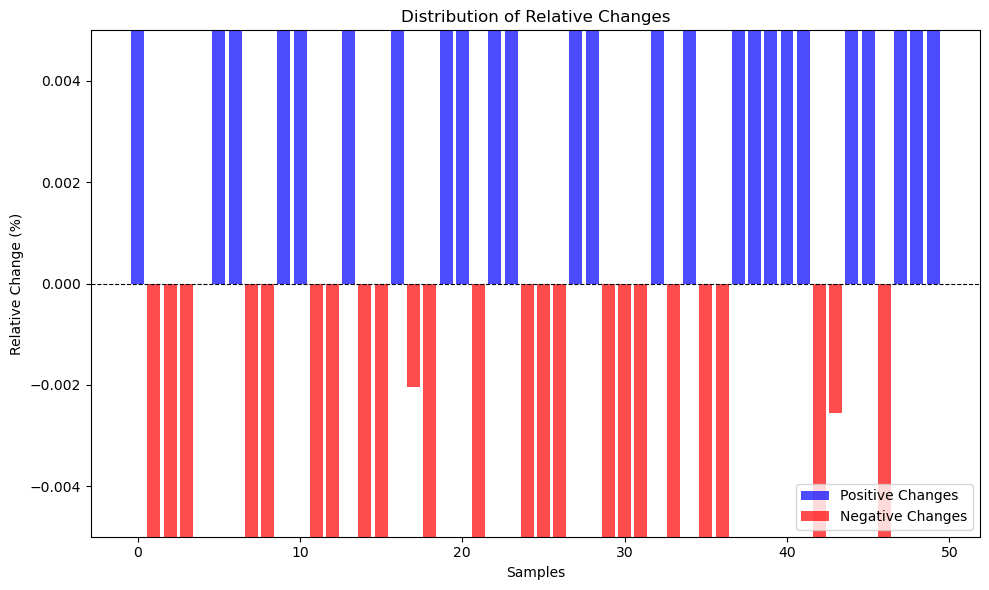


Explanations Contribution Score (ECS)          :  0.786
Overall Relative Change (ORC) positive changes :  23.641 %
Overall Relative Change (ORC) negative changes : -26.312 %


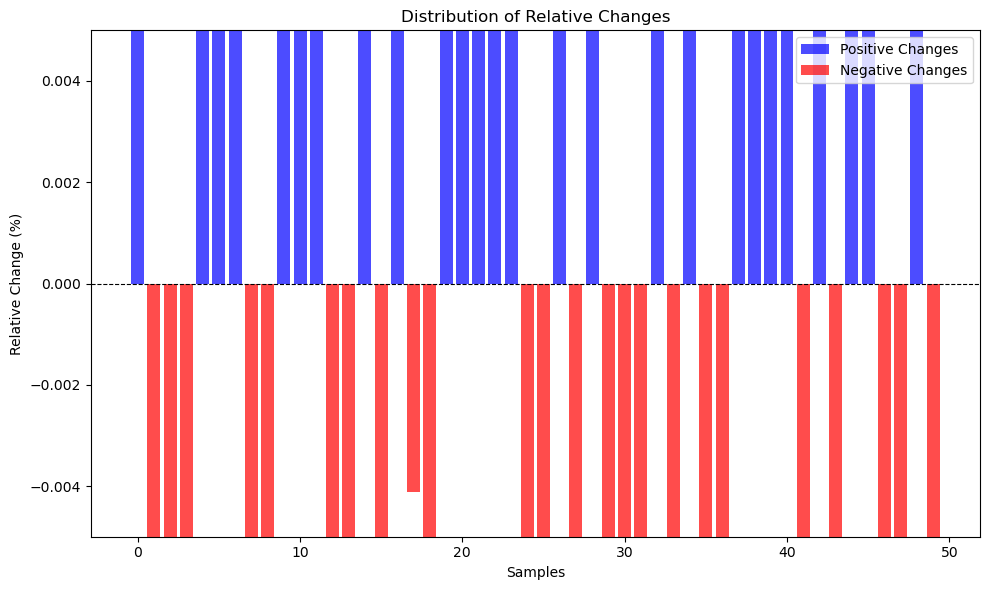

In [22]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [23]:
tc32_tbt_results = {}

for threshold in thresholds:

    rand_values_tc32 = apply_random(path_rand, tc32_test, tbt_model_tc32, tbt_tokenizer_tc32, 
                                   f"rand_values_tc32_{threshold}_tbt", device, only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(rand_values_tc32, tbt_tokenizer_tc32, threshold)

    rand_values_tc32_short = apply_random(path_rand, top_tokens_tc32, tbt_model_tc32, tbt_tokenizer_tc32, 
                                         f"rand_values_tc32_short_{threshold}_tbt", device, only_load=only_load)

    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    1,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    tbt_pipeline_text_tc32,
                                    pipeline_parameters,
                                    device, 
                                    tbt_id2label_tc32)

    tc32_tbt_results[threshold] = (rand_values_tc32, rand_values_tc32_short, tc32_tbt_result)
    
    clear_gpu_memory()
    
    show(tc32_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'rand_values_tc32_0.5_tbt' file shape: 50
'rand_values_tc32_short_0.5_tbt' file shape: 50


'rand_values_tc32_0.6_tbt' file shape: 50
'rand_values_tc32_short_0.6_tbt' file shape: 50


'rand_values_tc32_0.7_tbt' file shape: 50
'rand_values_tc32_short_0.7_tbt' file shape: 50



Explanations Contribution Score (ECS)          :  0.834
Overall Relative Change (ORC) positive changes :  19.651 %
Overall Relative Change (ORC) negative changes : -18.714 %


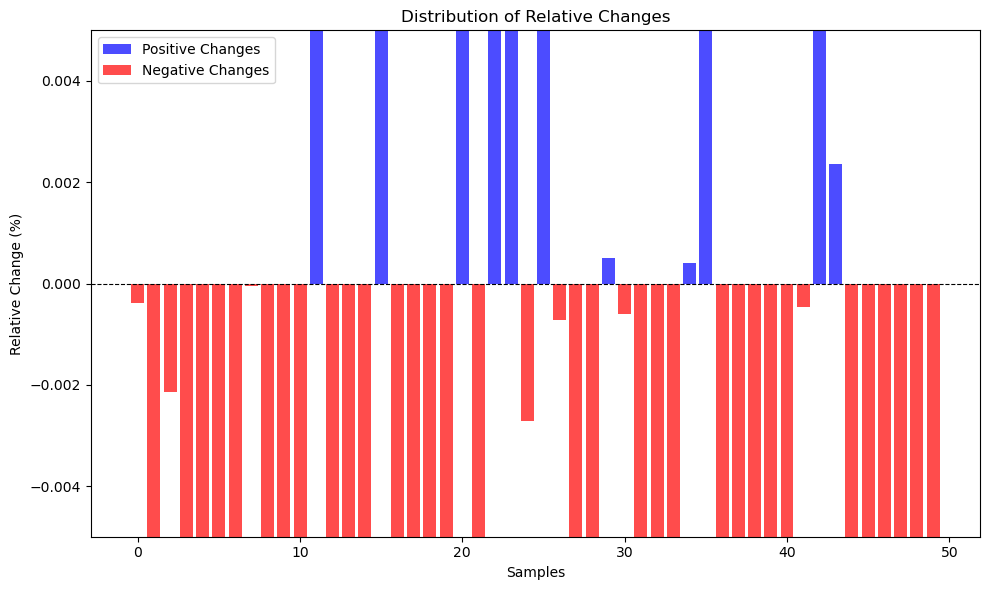


Explanations Contribution Score (ECS)          :  0.825
Overall Relative Change (ORC) positive changes :  17.483 %
Overall Relative Change (ORC) negative changes : -20.227 %


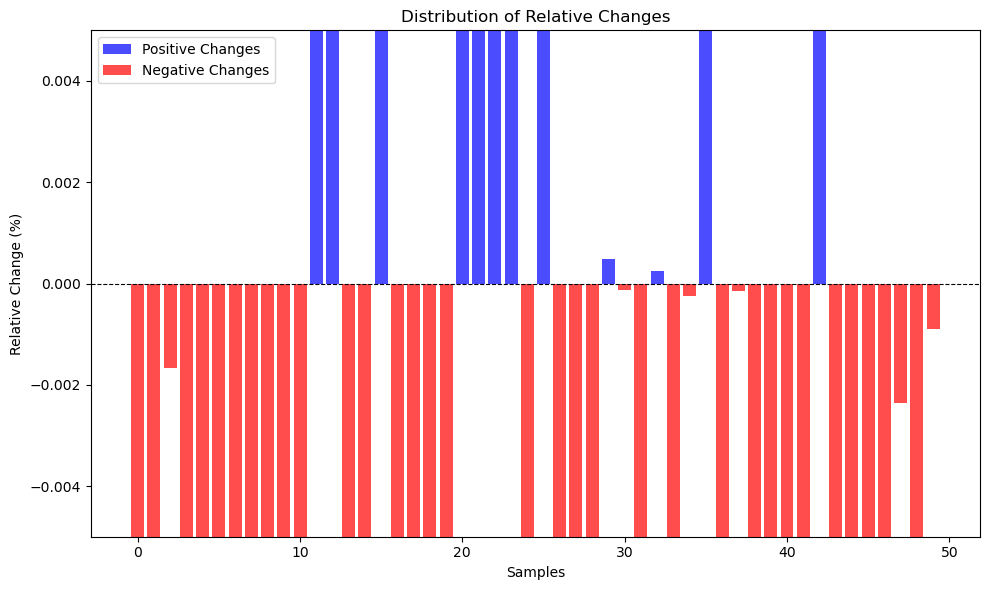


Explanations Contribution Score (ECS)          :  0.736
Overall Relative Change (ORC) positive changes :  17.296 %
Overall Relative Change (ORC) negative changes : -30.575 %


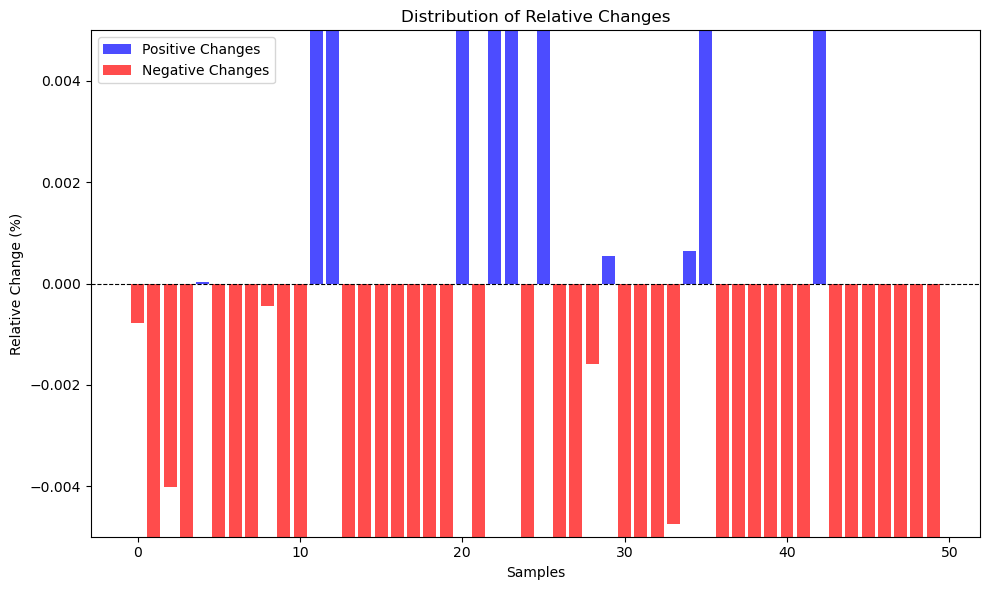

In [24]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

In [25]:
all_exp_results

,ECS,ORC (+),ORC (-)
0,0.975,4.967,-1.418
1,0.983,5.627,-0.558
2,0.956,6.198,-4.251
3,0.812,18.261,-18.207
4,0.796,16.385,-22.553
5,0.782,20.775,-22.485
6,0.925,9.354,-8.089
7,0.898,12.184,-13.631
8,0.896,12.123,-10.829
9,0.829,6.657,-18.180
